In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reducedthumbnaildataset/dataSetNew/testSet.txt
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainset1000.csv
/kaggle/input/reducedthumbnaildataset/dataSetNew/train_set.txt
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_489.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_1113.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_385.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_648.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_1044.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_198.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_1593.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_236.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_1938.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_571.jpg
/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_1580.jpg
/kaggle/input/reducedthumbnaildataset/dataSetN

In [2]:
#BASE_PATH = "/kaggle/input/dataset/dataSetNew"
IMAGES_PATH = "/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet"
ANNOTS_PATH = "/kaggle/input/reducedthumbnaildataset/dataSetNew/train_set.txt"

In [3]:
# define the path to the base output directory
BASE_OUTPUT = "/kaggle/working/output"
os.mkdir(BASE_OUTPUT)
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH1 = os.path.sep.join([BASE_OUTPUT, "plotLoss.png"])
PLOT_PATH2 = os.path.sep.join([BASE_OUTPUT, "plotAcc.png"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

In [4]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [5]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [6]:
# load the contents of the CSV annotations file
print("[INFO] loading dataset...")
rows = open(ANNOTS_PATH).read().strip().split("\n")
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
filenames = []

[INFO] loading dataset...


In [7]:
# loop over the rows
for row in rows:
    # break the row into the filename and bounding box coordinates
    row = row.split(";")
    filename = row[0]
    imagePath = os.path.sep.join([IMAGES_PATH, filename])
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    (startX, startY, endX, endY) = (n for n in row[2].split() if n)
    # scale the bounding box coordinates relative to the spatial
    # dimensions of the input image
    startX = float(startX) / float(w)
    startY = float(startY) / float(h)
    endX = float(endX) / float(w)
    endY = float(endY) / float(h)
    # load the image and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    # update our list of data, targets, and filenames
    data.append(image)
    targets.append((startX, startY, endX, endY))
    filenames.append(filename)

In [8]:
# convert the data and targets to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(data, targets, filenames, test_size=0.10,
	random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(TEST_FILENAMES, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


PREPARING VGG-16 MODEL FOR FINE TUNING

In [9]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt, metrics=['acc'])
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

serialize the model to disk and plot the training history

In [11]:
score = model.evaluate(testImages, testTargets, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.022812090814113617
Test accuracy: 0.49000000953674316


[INFO] saving object detector model...


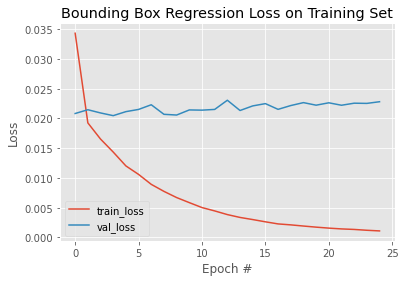

In [12]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH1)

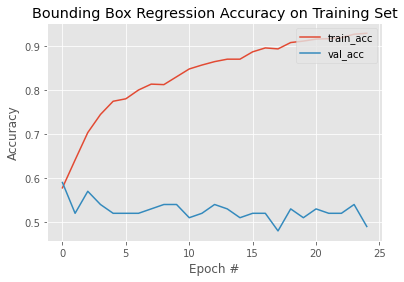

In [13]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Bounding Box Regression Accuracy on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.savefig(PLOT_PATH2)

In [14]:
filepth = "/kaggle/working/output/detector1.pkl"
model.save(filepth)

In [15]:
import pickle
import tensorflow as tf
model1 = tf.keras.optimizers.serialize(model)
filename = "detector3.pkl"
pickle.dump(model1, open(filename, 'wb'))

In [16]:
#import pickle
#import tensorflow as tf
#filename = "detector.pkl"
#pickle.dump(model, open(filename, 'wb'))
#tf.keras.models.save_model(model, filename)

bounding box prediction

In [17]:
# import the necessary packages

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
from PIL import Image 
import cv2
import os

In [18]:
# construct the argument parser and parse the arguments
'''ap = argparse.ArgumentParser()
ap.add_argument("-i", "--input", required=True,
	help="path to input image/text file of image filenames")
args = vars(ap.parse_args())'''

'ap = argparse.ArgumentParser()\nap.add_argument("-i", "--input", required=True,\n\thelp="path to input image/text file of image filenames")\nargs = vars(ap.parse_args())'

In [19]:
'''# determine the input file type, but assume that we're working with
# single input image
filetype = mimetypes.guess_type(args["input"])[0]
imagePaths = [args["input"]]
# if the file type is a text file, then we need to process *multiple*
# images
if "text/plain" == filetype:
	# load the filenames in our testing file and initialize our list
	# of image paths
	filenames = open(args["input"]).read().strip().split("\n")
	imagePaths = []
	# loop over the filenames
	for f in filenames:
        # construct the full path to the image filename and then
        # update our image paths list
        p = os.path.sep.join([IMAGES_PATH, f])
        imagePaths.append(p)'''

'# determine the input file type, but assume that we\'re working with\n# single input image\nfiletype = mimetypes.guess_type(args["input"])[0]\nimagePaths = [args["input"]]\n# if the file type is a text file, then we need to process *multiple*\n# images\nif "text/plain" == filetype:\n\t# load the filenames in our testing file and initialize our list\n\t# of image paths\n\tfilenames = open(args["input"]).read().strip().split("\n")\n\timagePaths = []\n\t# loop over the filenames\n\tfor f in filenames:\n        # construct the full path to the image filename and then\n        # update our image paths list\n        p = os.path.sep.join([IMAGES_PATH, f])\n        imagePaths.append(p)'

In [20]:
print("[INFO] loading object detector...")
model = load_model('/kaggle/working/output/detector.h5')

[INFO] loading object detector...


In [21]:
from torchvision.io import read_image
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

(0.08648514, 0.305191, 0.8659425, 0.8233854)


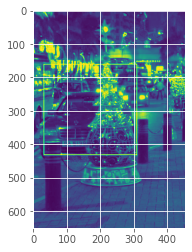

In [22]:
image = load_img('/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_365.jpg', target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# make bounding box predictions on the input image
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds
print((startX, startY, endX, endY))
image = cv2.imread(imagePath)
(h,w) = image.shape[:2]
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
imagePath = '/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_365.jpg'
img = read_image(imagePath)
bbox = [startX, startY, endX, endY]
bbox = torch.tensor(bbox, dtype=torch.int)
bbox = bbox.unsqueeze(0)
img=draw_bounding_boxes(img, bbox, width=3, colors=(255,255,255))
plt.imshow(img.numpy()[0])

In [23]:
from PIL import Image
import PIL
import numpy as np

In [24]:
def produceFinalThumbnail(imagePath, h, w, filename):
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    # make bounding box predictions on the input image
    preds = model.predict(image)[0]
    (startX, startY, endX, endY) = preds
    
    image = cv2.imread(imagePath)
    (ho,wo) = image.shape[:2]
    startX = int(startX * wo)
    startY = int(startY * ho)
    endX = int(endX * wo)
    endY = int(endY * ho)
    #plt.imshow(image)
    cropped_image = image[int(startY):int(endY), int(startX):int(endX)]
    
    #plt.imshow(cropped_image)
    resized_image = cv2.resize(cropped_image, (w,h))
    plt.imshow(resized_image)
    resized_image = resized_image.astype('uint8')
    img = Image.fromarray(resized_image, "RGB")
    img.save(filename)

In [25]:
def genThumbnail(imagePath, w, h, finalPath):
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    # make bounding box predictions on the input image
    preds = model.predict(image)[0]
    (startX, startY, endX, endY) = preds
    
    image = cv2.imread(imagePath)
    (ho,wo) = image.shape[:2]
    startX = int(startX * wo)
    startY = int(startY * ho)
    endX = int(endX * wo)
    endY = int(endY * ho)
    
    im = Image.open(imagePath)
    im1 = im.crop((startX, startY, endX, endY))
    im1 = im1.resize((w,h))
    im1.save(finalPath)

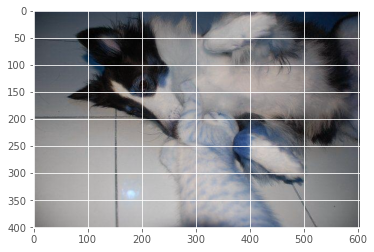

In [26]:
image = cv2.imread('/kaggle/input/reducedthumbnaildataset/dataSetNew/trainSet/PQ_1012.jpg')
plt.imshow(image)

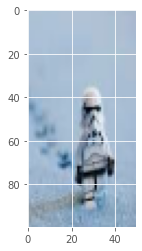

In [27]:
produceFinalThumbnail('/kaggle/input/testimages/astro.jpeg', 100, 50, "thumbnail1.jpg")

In [28]:
genThumbnail('/kaggle/input/testimages/dog.jpeg', 100, 100, "dog100x100DL.jpg")

In [29]:
genThumbnail('/kaggle/input/testimages/flower.jpeg', 100, 100, "flower100x100DL.jpg")

In [30]:
genThumbnail('/kaggle/input/testimages/dog.jpeg', 50, 100, "dog50x100DL.jpg")

In [31]:
genThumbnail('/kaggle/input/testimages/flower.jpeg', 50, 100, "flower50x100DL.jpg")

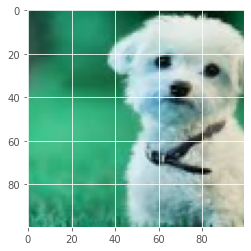

In [32]:
produceFinalThumbnail('/kaggle/input/testimages/dog.jpeg', 100, 100, "dog100x100DL.jpg")

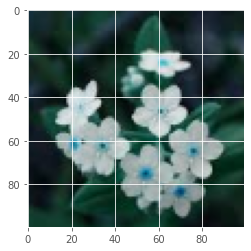

In [33]:
produceFinalThumbnail('/kaggle/input/testimages/flower.jpeg', 100, 100, "flower100x100DL.jpg")

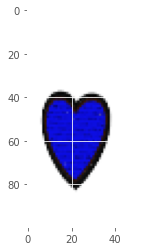

In [34]:
produceFinalThumbnail('/kaggle/input/testimages/heart.png', 100, 50, "thumbnail4.jpg")

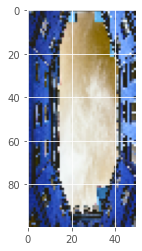

In [35]:
produceFinalThumbnail('/kaggle/input/compleximages/adrian-trinkaus-7UCmXtyg1CQ-unsplash.jpg', 100, 50, "complexT1.jpg")

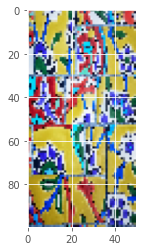

In [36]:
produceFinalThumbnail('/kaggle/input/compleximages/hasan-almasi-o_JU7aQCHPQ-unsplash.jpg', 100, 50, "complexT2.jpg")